## Imports

In [1]:
# Add parent directory to path for local imports
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler
%matplotlib inline

In [2]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [3]:
transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = dset.ImageFolder('../Dataset/train', transform=transform)
val_dataset = dset.ImageFolder('../Dataset/val', transform=transform)
test_dataset = dset.ImageFolder('../Dataset/test', transform=transform)

In [4]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Creating DenseNet model

In [6]:
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Linear(1024, 172)
optimizer = optim.Adam(model.parameters())
print(model)
model = gpu(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Training the model

In [7]:
def train_model(model, optimizer, epochs=1):
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    for epoch in range(epochs):
        model.train()
        batches = train_dataloader
        num_correct, num_samples, total_loss = 0, 0, 0
        for x, y in batches:
            x, y = gpu(x), gpu(y)
            scores = model(x)
            loss = F.cross_entropy(scores, y)           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(scores.data,1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
        train_loss_history.append(average_loss)
        train_accuracy_history.append(acc)
        print('Epoch: {} Training Loss: {:.4f} Got {} / {} correct. Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        
        check_accuracy(model, val_loss_history, val_accuracy_history, epoch)
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

def check_accuracy(model, val_loss_history, val_accuracy_history, epoch):
    num_correct, num_samples, total_loss = 0, 0, 0
    model.eval()
    batches = val_dataloader
    with torch.no_grad():
        for x, y in batches:
            x, y = gpu(x), gpu(y)                
            scores = model(x)
            loss = F.cross_entropy(scores, y) 
            _, preds = torch.max(scores.data, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
    val_loss_history.append(average_loss)
    val_accuracy_history.append(acc)
    print('Epoch: {} Validation Loss: {:.4f} Got {} / {} correct {:.2f}%'.format(
        epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        

In [8]:
%%time
LOSS, ACC, LOSS_V, ACC_V = train_model(gpu(model), optimizer, epochs=20)

Epoch: 1 Training Loss: 0.0378 Got 31812 / 66071 correct. Acc: 48.15%
Epoch: 1 Validation Loss: 0.0248 Got 6769 / 11016 correct 61.45%
Epoch: 2 Training Loss: 0.0221 Got 42706 / 66071 correct. Acc: 64.64%
Epoch: 2 Validation Loss: 0.0216 Got 7170 / 11016 correct 65.09%
Epoch: 3 Training Loss: 0.0190 Got 45406 / 66071 correct. Acc: 68.72%
Epoch: 3 Validation Loss: 0.0206 Got 7248 / 11016 correct 65.80%
Epoch: 4 Training Loss: 0.0173 Got 46936 / 66071 correct. Acc: 71.04%
Epoch: 4 Validation Loss: 0.0200 Got 7379 / 11016 correct 66.98%
Epoch: 5 Training Loss: 0.0162 Got 47923 / 66071 correct. Acc: 72.53%
Epoch: 5 Validation Loss: 0.0198 Got 7335 / 11016 correct 66.58%
Epoch: 6 Training Loss: 0.0154 Got 48608 / 66071 correct. Acc: 73.57%
Epoch: 6 Validation Loss: 0.0196 Got 7407 / 11016 correct 67.24%
Epoch: 7 Training Loss: 0.0148 Got 49094 / 66071 correct. Acc: 74.30%
Epoch: 7 Validation Loss: 0.0201 Got 7358 / 11016 correct 66.79%
Epoch: 8 Training Loss: 0.0142 Got 49731 / 66071 correc

In [10]:
# Save the model.
PATH = "../saved_models/food/densenet/densenet.dat"
torch.save(model, PATH)
torch.save({'loss': LOSS, 'acc': ACC, 'loss_v': LOSS_V, 'acc_v': ACC_V}, '../saved_models/food/densenet/densenet-history.pt')

## Evaluation

In [11]:
# Load the model.
PATH = "../saved_models/food/densenet/densenet.dat"
loaded_model = torch.load(PATH)
loaded_model = gpu(loaded_model)
model = loaded_model
history = torch.load('../saved_models/food/densenet/densenet-history.pt')
LOSS, ACC, LOSS_V, ACC_V = (history['loss'], history['acc'], history['loss_v'], history['acc_v'])

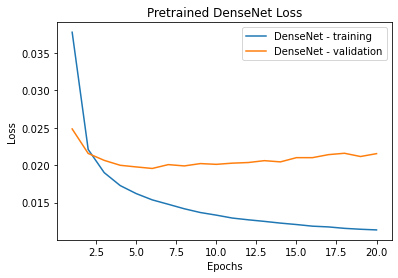

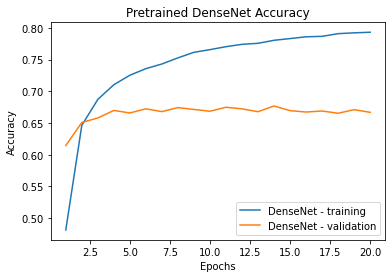

In [12]:
# Loss and Accuracy Curves
from utils.plots import plot_loss_and_accuracy_curves
plot_loss_and_accuracy_curves('DenseNet', LOSS, ACC, LOSS_V, ACC_V)

In [13]:
# Evaluation: Top-1 Accuracy

def compute_top_1_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Top 1 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))

compute_top_1_accuracy(model)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Top 1 Accuracy of the network on the all test images: 67.07 %


In [14]:
# Evaluation: Top-5 Accuracy

def compute_top_5_accuracy(model):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in test_dataloader:
            images, labels = data
            images = gpu(images)
            labels = gpu(labels)
            outputs = model(images)
            _, predicted = torch.topk(outputs.data, 5, dim=1)
            total += labels.size(0)
            for i in range(predicted.shape[0]):
                top_5_predictions = predicted[i]
                label = labels[i]
                if label in top_5_predictions:
                    correct += 1
    print('Top 5 Accuracy of the network on the all test images: %.2f %%' % (
        100 * correct / total))
    
compute_top_5_accuracy(model)

Top 5 Accuracy of the network on the all test images: 88.26 %


In [15]:
import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [16]:
# Store y_pred and y_test on the test set for evaluation.

y_pred = []
y_test = []
with torch.no_grad():
    model.eval()
    for data in test_dataloader:
        images, labels = data
        images = gpu(images)
        labels = gpu(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_test.extend(labels.cpu().numpy().tolist())

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [17]:
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(cnf_matrix)
print(cnf_matrix[0][0], sum(cnf_matrix[0]))

Confusion Matrix

[[153   4   0 ...   0   1   0]
 [  3 193   0 ...   0   0   0]
 [  0   0  50 ...   0   0   0]
 ...
 [  0   0   0 ...  58   0   0]
 [  0   0   0 ...   1  37   2]
 [  0   0   0 ...   1   0 138]]
153 307


<AxesSubplot:>

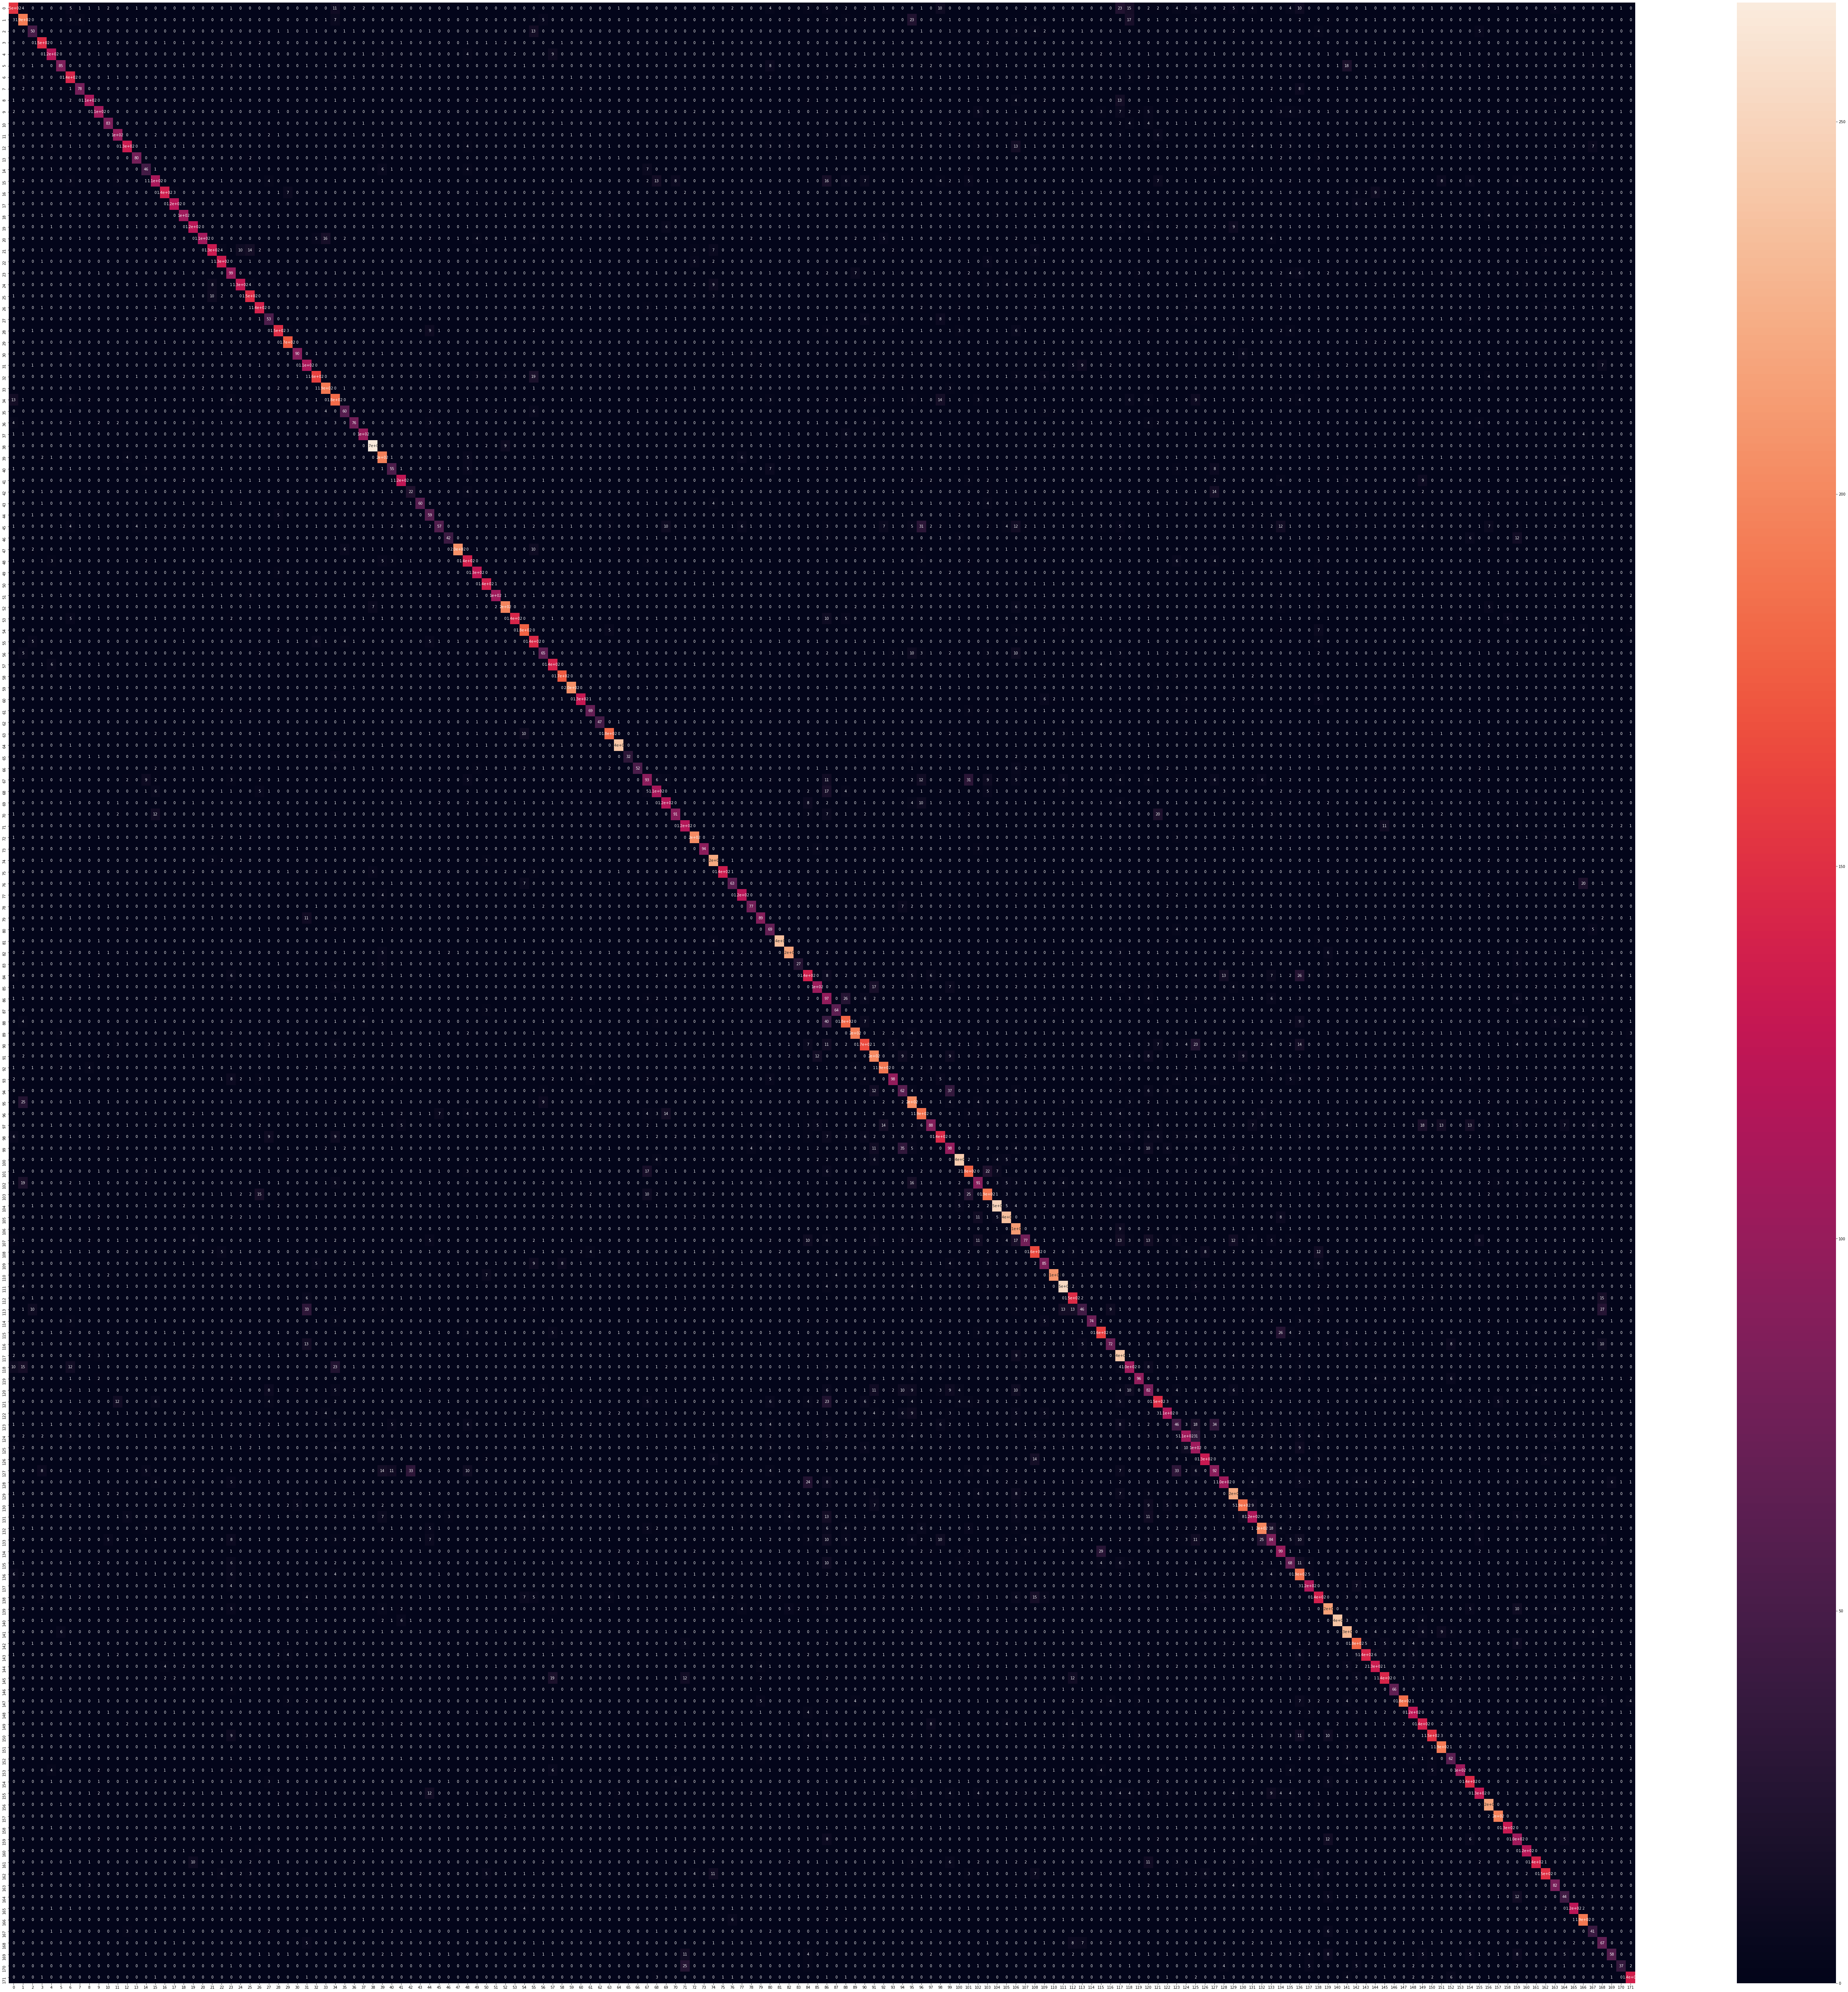

In [18]:
# Visualizing the confusion matrix 

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = cnf_matrix.tolist()
df_cm = pd.DataFrame(array, index = [i for i in range(172)],
                  columns = [i for i in range(172)])
plt.figure(figsize = (100,100))
sn.heatmap(df_cm, annot=True)

In [19]:
# Evaluation: Compute several statistics such as accuracy, precision, F1-score, and produce a classification report

FOOD_LIST_PATH = '../VireoFood172/SplitAndIngreLabel/FoodList.txt'
food_names = [] # List of length 172 where index is the food label, and value is the food name.
with open(FOOD_LIST_PATH) as fp:
    food_names = fp.read().splitlines()
    
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=food_names))


Accuracy: 0.67

Micro Precision: 0.67
Micro Recall: 0.67
Micro F1-score: 0.67

Macro Precision: 0.69
Macro Recall: 0.67
Macro F1-score: 0.67

Weighted Precision: 0.68
Weighted Recall: 0.67
Weighted F1-score: 0.67

Classification Report

                                              precision    recall  f1-score   support

                                Braised Pork       0.65      0.50      0.56       307
                          Sautéed Spicy Pork       0.62      0.67      0.65       287
             Cripsy sweet & sour pork slices       0.66      0.51      0.57        98
               Steamed pork with rice powder       0.79      0.88      0.83       168
                  Pork with salted vegetable       0.81      0.76      0.78       156
                   Shredded Pork with pepper       0.80      0.56      0.66       152
                     Yu-Shiang Shredded Pork       0.59      0.80      0.68       178
  Sautéed Sliced Pork, Eggs and Black Fungus       0.75      0.76      0.

In [20]:
print(len(y_test))

33154


In [21]:
# Class 0 Statistics

TP = 0
FP = 0
FN = 0
for pred,label in zip(y_pred, y_test):
    if pred == 0 and label == 0:
        TP += 1
    if pred == 0 and label != 0:
        FP += 1
    if pred != 0 and label == 0:
        FN += 1
print("Class 0 ({}) Statistics".format(food_names[0]))
print("True Positives: {}".format(TP))
print("False Positives: {}".format(FP))
print("False Negatives: {}".format(FN))
print("Precision: {}".format(TP / (TP + FP)))
print("Recall: {}".format(TP / (TP + FN)))

Class 0 (Braised Pork) Statistics
True Positives: 153
False Positives: 84
False Negatives: 154
Precision: 0.6455696202531646
Recall: 0.498371335504886
